# Introduction to Convolutional Neural Networks (CNNs)

## Session 4: End-2-End Framework of a Deep CNN for Image Classification

Welcome to the exciting world of Convolutional Neural Networks!

Author: [Parham Kebria, PhD](https://parhamkebria.com)

### In this session, we'll explore:

1. **Normalizations & Dropout**
2. **Activation Functions**
3. **Model Architectures**
4. **Data Preprocessing**
5. **Data Augmentation**
6. **Transfer Learning**
7. **Hyperparameter Tuning**

### Let's dive into the world of spatial intelligence!


## 📄 Copyright & License Notice

**© 2025 Parham Kebria. All Rights Reserved.**

This notebook is protected by copyright law. Unauthorized reproduction, distribution, modification, or commercial use is strictly prohibited without written permission from the author.

**Permitted Use:**

- Personal learning and education
- Academic research (with proper citation)
- Classroom instruction (with attribution)

**Prohibited Use:**

- Commercial redistribution
- Modification without permission
- Removal of copyright notices
- Claiming authorship

**Citation Required:** When referencing this work, please cite:

```
Kebria, P. (2025). Deep Learning for Image Classification.
```

**Contact:** For licensing inquiries, contact [Parham Kebria](https://parhamkebria.com)

---


### Libraries


In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import torchvision.models as models
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import jaccard_score 

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.2.2
NumPy version: 1.26.0


### Configurations


In [ ]:

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# General hyperparameters (tweak as needed)
CFG = dict(
    seed=42,
    img_size=(256, 256),   # resize for network
    batch_size=8,
    lr=1e-3,
    num_epochs=3,
    val_split=0.2,
    weight_decay=1e-4,
    dropout_p=0.3,
    activation="relu",  # try "relu", "leaky_relu", "elu"
    num_workers=0,
)

# For reproducibility
torch.manual_seed(CFG["seed"])
np.random.seed(CFG["seed"])
random.seed(CFG["seed"])

# Set data paths
DATA_ROOT = "/path/to/datasets/Flood Area Segmentation" # set this
IMAGE_DIR = os.path.join(DATA_ROOT, "Image")
MASK_DIR = os.path.join(DATA_ROOT, "Mask")
METADATA = pd.read_csv(os.path.join(DATA_ROOT, "metadata.csv"), low_memory=False)
print(f"METADATA: {METADATA.shape[0]}x{METADATA.shape[1]}")

Using device: cpu
METADATA: 290x2


### Utilities and Helper Functions


In [3]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy()

def iou_score(pred_mask: np.ndarray, true_mask: np.ndarray, eps=1e-7):
    """IoU for binary masks (arrays of 0/1)."""
    pred = (pred_mask > 0.5).astype(np.uint8).reshape(-1)
    true = (true_mask > 0.5).astype(np.uint8).reshape(-1)
    inter = (pred & true).sum()
    union = (pred | true).sum()
    return (inter + eps) / (union + eps)

def dice_score(pred_mask: np.ndarray, true_mask: np.ndarray, eps=1e-7):
    pred = (pred_mask > 0.5).astype(np.uint8).reshape(-1)
    true = (true_mask > 0.5).astype(np.uint8).reshape(-1)
    inter = (pred & true).sum()
    return (2 * inter + eps) / (pred.sum() + true.sum() + eps)

def get_activation(name="relu"):
    if name == "relu":
        return nn.ReLU(inplace=True)
    elif name == "leaky_relu":
        return nn.LeakyReLU(0.1, inplace=True)
    elif name == "elu":
        return nn.ELU(inplace=True)
    else:
        raise ValueError("Unsupported activation name")

### Dataset Preparation


In [4]:
class FloodDataset(Dataset):
    """
    Expects:
    - IMAGE_DIR contains RGB images (jpg/png)
    - MASK_DIR contains masks with same filenames (png) where flooded region is white (255) or 1.
    """
    def __init__(self, image_dir: str, mask_dir: str, transforms: Optional[transform.Compose] = None):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*")))
        # Basic filename matching check:
        assert len(self.image_paths) == len(self.mask_paths), "Images and masks count mismatch"
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def _load_image(self, path):
        return Image.open(path).convert("RGB")

    def _load_mask(self, path):
        m = Image.open(path).convert("L")  # single channel
        # Convert to binary in case mask uses 0/255
        return m

    def __getitem__(self, idx):
        img = self._load_image(self.image_paths[idx])
        mask = self._load_mask(self.mask_paths[idx])

        if self.transforms:
            # Expect transforms that accept both image and mask (custom below)
            img, mask = self.transforms(img, mask)

        return img, mask

### Transforms — Data Preprocessing & Augmentation


In [5]:
class SegmentationTransform:
    """
    Compose transforms that apply identically to image and mask.
    Note: image transforms should be PIL-image based or torchvision transforms expecting PIL.
    Masks will be nearest-neighbor resized / transformed to preserve labels.
    """
    def __init__(self,
                size: Tuple[int, int] = (256, 256),
                horizontal_flip: float = 0.5,
                vertical_flip: float = 0.0,
                rotation: float = 10.0,
                brightness: float = 0.2,
                contrast: float = 0.2,
                normalize_mean=(0.485, 0.456, 0.406),
                normalize_std=(0.229, 0.224, 0.225),
                to_tensor=True):
        self.size = size
        self.hf = horizontal_flip
        self.vf = vertical_flip
        self.rot = rotation
        self.brightness = brightness
        self.contrast = contrast
        self.normalize = transform.Normalize(mean=normalize_mean, std=normalize_std)
        self.to_tensor = to_tensor

    def __call__(self, img: Image.Image, mask: Image.Image):
        # Resize both
        img = img.resize(self.size, resample=Image.BILINEAR)
        mask = mask.resize(self.size, resample=Image.NEAREST)

        # Random flips
        if random.random() < self.hf:
            img = transform.functional.hflip(img)
            mask = transform.functional.hflip(mask)
        if random.random() < self.vf:
            img = transform.functional.vflip(img)
            mask = transform.functional.vflip(mask)

        # Random rotation
        angle = random.uniform(-self.rot, self.rot)
        img = img.rotate(angle, resample=Image.BILINEAR)
        mask = mask.rotate(angle, resample=Image.NEAREST)

        # Color jitter (image only)
        color_jitter = transform.ColorJitter(brightness=self.brightness, contrast=self.contrast)
        img = color_jitter(img)

        # Convert to tensor & normalize
        img = transform.functional.to_tensor(img)  # yields [0,1]
        img = self.normalize(img)

        # Mask -> tensor (0 or 1)
        mask = np.array(mask).astype(np.float32)
        # If mask has 255 for flooded region, convert to 1
        mask = (mask > 127).astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)  # 1xHxW

        return img, mask

# Visualization helper
def show_image_and_mask(img_tensor: torch.Tensor, mask_tensor: torch.Tensor, title: str = ""):
    # img_tensor: CxHxW (normalized) -> denormalize for display
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    # Simple de-normalize with ImageNet stats used above
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = (img * std) + mean
    img = np.clip(img, 0, 1)

    mask = mask_tensor.cpu().squeeze(0).numpy()

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")
    if title:
        plt.suptitle(title)
    plt.show()


## Model Architecture


### simple encoder-decoder & small CNN baseline


In [6]:
class SimpleSegNet(nn.Module):
    """
    A compact encoder-decoder segmentation net for experimentation.
    Uses CFG['dropout_p'] and activation selection.
    """
    def __init__(self, in_channels=3, out_channels=1, base_filters=32, activation="relu", dropout_p=0.3):
        super().__init__()
        act = get_activation(activation)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_filters, 3, padding=1),
            nn.BatchNorm2d(base_filters),
            act,
            nn.MaxPool2d(2),

            nn.Conv2d(base_filters, base_filters*2, 3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            act,
            nn.MaxPool2d(2),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(base_filters*2, base_filters*4, 3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            act,
            nn.Dropout2d(p=dropout_p)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_filters*4, base_filters*2, kernel_size=2, stride=2),
            act,
            nn.ConvTranspose2d(base_filters*2, base_filters, kernel_size=2, stride=2),
            act,
            nn.Conv2d(base_filters, out_channels, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)  # final probability map
        return x

### binary classifier head (Fully-Connected)


In [7]:
class SmallBinaryClassifierCNN(nn.Module):
    """
    Example: reduce segmentation to patch-wise or downsampled segmentation by predicting a coarse map.
    Included for architecture comparison.
    """
    def __init__(self, activation="relu", dropout_p=0.25):
        super().__init__()
        act = get_activation(activation)
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            act,
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            act,
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            act,
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # returns single probability per image (not per-pixel) — baseline experiment
        return self.net(x)

## Training and validation


In [8]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device, max_samples_to_visualize=3):
    model.eval()
    val_loss = 0.0
    ious = []
    dices = []
    visualized = 0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            # compute metrics per image
            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()
            for i in range(preds_np.shape[0]):
                p = preds_np[i, 0, :, :]
                m = masks_np[i, 0, :, :]
                ious.append(iou_score(p, m))
                dices.append(dice_score(p, m))
                if visualized < max_samples_to_visualize:
                    show_image_and_mask(imgs[i].cpu(), masks[i].cpu(), title=f"Val Sample (IoU: {ious[-1]:.3f} Dice: {dices[-1]:.3f})")
                    # Overlay predicted mask on image
                    img_vis = imgs[i].cpu().permute(1, 2, 0).numpy()
                    mean = np.array([0.485, 0.456, 0.406]); std = np.array([0.229, 0.224, 0.225])
                    img_vis = (img_vis * std) + mean
                    img_vis = np.clip(img_vis, 0, 1)
                    fig, ax = plt.subplots(1, figsize=(4, 4))
                    ax.imshow(img_vis)
                    ax.imshow((p > 0.5).astype(float), alpha=0.35, cmap='Reds')
                    ax.set_title("Prediction overlay")
                    ax.axis("off")
                    plt.show()
                    visualized += 1

    avg_loss = val_loss / len(dataloader.dataset)
    avg_iou = float(np.mean(ious)) if ious else 0.0
    avg_dice = float(np.mean(dices)) if dices else 0.0
    return avg_loss, avg_iou, avg_dice

### Loss Functions


In [9]:
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCELoss()
        self.bce_weight = bce_weight

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        # Dice
        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)
        intersection = (pred_flat * target_flat).sum(1)
        dice = (2. * intersection + 1e-7) / (pred_flat.sum(1) + target_flat.sum(1) + 1e-7)
        dice_loss = 1 - dice.mean()
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

## Training (Baseline model)


In [10]:
def train_SimpleSegNet():
    # Transforms
    seg_transforms = SegmentationTransform(size=CFG["img_size"],
                                            horizontal_flip=0.5,
                                            rotation=10.0,
                                            brightness=0.2,
                                            contrast=0.2)

    # Dataset
    dataset = FloodDataset(IMAGE_DIR, MASK_DIR, transforms=seg_transforms)
    n = len(dataset)
    n_val = int(n * CFG["val_split"])
    n_train = n - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    print(f"Dataset size: {n}, train: {n_train}, val: {n_val}")

    train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, num_workers=CFG["num_workers"])
    val_loader   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"])

    # Visualize a few training samples (pre-augmentation view)
    print("Visualizing a few training examples (after transforms)...")
    for i in range(2):
        img, m = train_ds[i]
        show_image_and_mask(img, m, title=f"Train sample #{i}")

    model = SimpleSegNet(in_channels=3, out_channels=1, base_filters=32,
                        activation=CFG["activation"], dropout_p=CFG["dropout_p"]).to(DEVICE)
    print("Using SimpleSegNet; model param count:", sum(p.numel() for p in model.parameters()))

    # Loss & optimizer
    criterion = BCEDiceLoss(bce_weight=0.5)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

    # Training loop (light)
    best_val_iou = 0.0
    for epoch in tqdm(range(1, CFG["num_epochs"] + 1), desc="Training Epochs"):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_iou, val_dice = evaluate(model, val_loader, criterion, DEVICE, max_samples_to_visualize=1)
        tqdm.write(f"Epoch {epoch:02d} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_iou={val_iou:.4f} val_dice={val_dice:.4f}")
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), "best_simple_segnet.pth")
            tqdm.write("Saved best model.")


Dataset size: 290, train: 232, val: 58
Visualizing a few training examples (after transforms)...


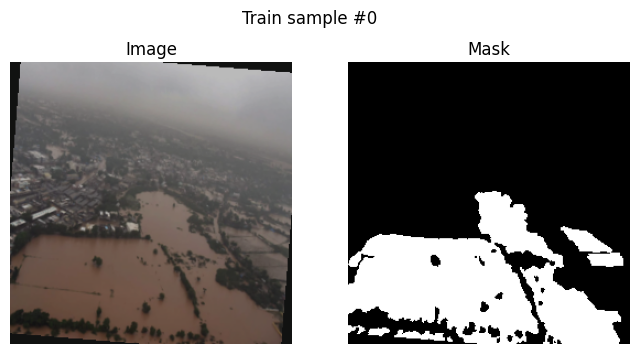

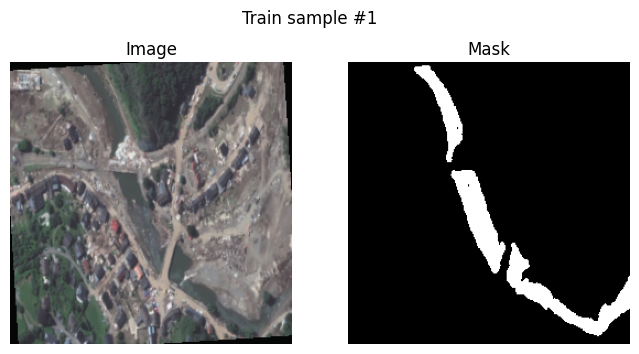

Using SimpleSegNet; model param count: 134785


Training Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

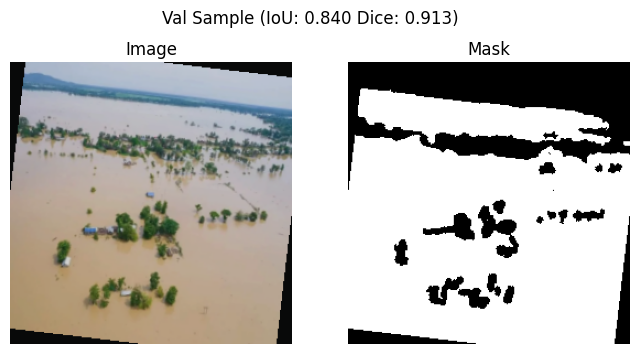

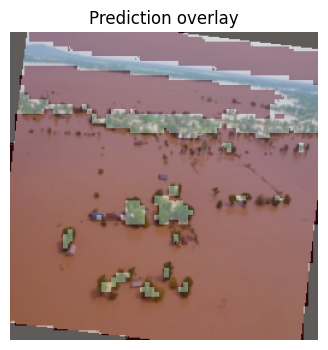

Epoch 01 train_loss=0.5181 val_loss=0.4969 val_iou=0.5825 val_dice=0.7155
Saved best model.


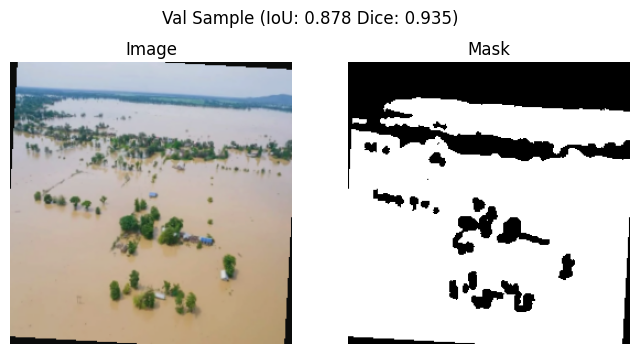

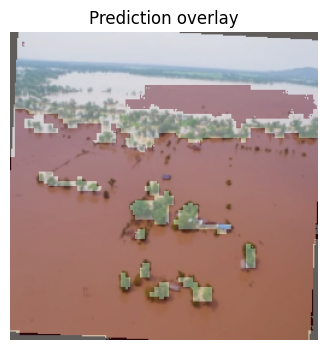

Epoch 02 train_loss=0.3915 val_loss=0.3359 val_iou=0.6389 val_dice=0.7647
Saved best model.


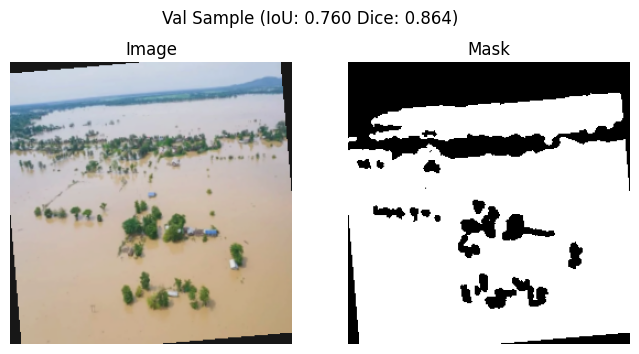

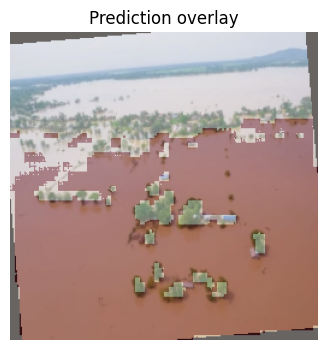

Epoch 03 train_loss=0.3749 val_loss=0.3452 val_iou=0.6327 val_dice=0.7535


In [11]:
train_SimpleSegNet()

# Transfer Learning

VGG16 encoder + new classifier head for segmentation
Strategy:

- Use pretrained VGG16 features as frozen encoder
- Add a simple decoder/classifier head (conv transpose or upsample + conv)

### VGG-16 with frozen layers


In [12]:
class VGG16_Frozen_Transfer(nn.Module):
    def __init__(self, pretrained=True, num_classes=1, dropout_p=0.3):
        super().__init__()
        # Load VGG16 with updated weights parameter
        try:
            if pretrained:
                vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            else:
                vgg = models.vgg16(weights=None)
        except Exception as e:
            print("Warning: couldn't load pretrained weights (maybe offline). Using uninitialized VGG16.")
            vgg = models.vgg16(weights=None)
        # Freeze conv layers
        for p in vgg.features.parameters():
            p.requires_grad = False
        self.features = vgg.features  # frozen conv stack
        # Build a decoder head — simple upsampling decoder
        # After VGG16 features, spatial size is reduced by factor of 32 (2^5)
        # For 256x256 input -> 8x8 feature map, so we need 5 upsampling stages
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),  # 8->16

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),  # 16->32

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),  # 32->64

            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),  # 64->128

            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),  # 128->256

            nn.Conv2d(16, num_classes, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        return x

## Training VGG-16 (Transfer Learning)


In [13]:
def train_TL_VGG16():
    # Transforms
    seg_transforms = SegmentationTransform(size=CFG["img_size"],
                                            horizontal_flip=0.5,
                                            rotation=10.0,
                                            brightness=0.2,
                                            contrast=0.2)

    # Dataset
    dataset = FloodDataset(IMAGE_DIR, MASK_DIR, transforms=seg_transforms)
    n = len(dataset)
    n_val = int(n * CFG["val_split"])
    n_train = n - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    print(f"Dataset size: {n}, train: {n_train}, val: {n_val}")

    train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, num_workers=CFG["num_workers"])
    val_loader   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"])
    transfer_model = VGG16_Frozen_Transfer(pretrained=True, num_classes=1, dropout_p=CFG["dropout_p"]).to(DEVICE)
    print("Total params:", sum(p.numel() for p in transfer_model.parameters()))
    print("Trainable params:", sum(p.numel() for p in transfer_model.parameters() if p.requires_grad))

    # Replace optimizer to only update trainable params
    optimizer_t = optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
    criterion_t = BCEDiceLoss(bce_weight=0.5)

    # Training loop with tqdm progress bar
    best_val_iou = 0.0
    for epoch in tqdm(range(1, int(CFG["num_epochs"] / 2) + 1), desc="Transfer Learning Epochs"):
        tloss = train_one_epoch(transfer_model, train_loader, criterion_t, optimizer_t, DEVICE)
        vloss, viou, vdice = evaluate(transfer_model, val_loader, criterion_t, DEVICE, max_samples_to_visualize=1)
        tqdm.write(f"TL Epoch {epoch:02d} train_loss={tloss:.4f} val_loss={vloss:.4f} val_iou={viou:.4f} val_dice={vdice:.4f}")
        if viou > best_val_iou:
            best_val_iou = viou
            torch.save(transfer_model.state_dict(), "vgg16_transfer.pth")
            tqdm.write("Saved best transfer learning model.")

Dataset size: 290, train: 232, val: 58
Total params: 16287521
Trainable params: 1572833
Total params: 16287521
Trainable params: 1572833


Transfer Learning Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

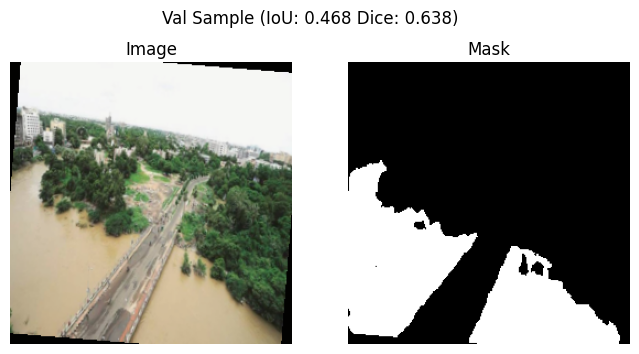

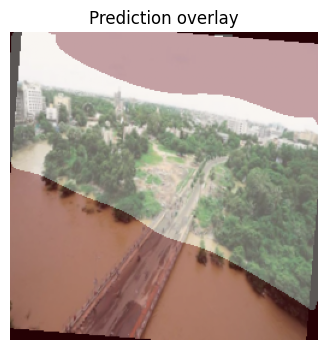

TL Epoch 01 train_loss=0.5322 val_loss=0.4601 val_iou=0.5193 val_dice=0.6525
Saved best transfer learning model.


In [14]:
train_TL_VGG16()

## Inference and Visualization


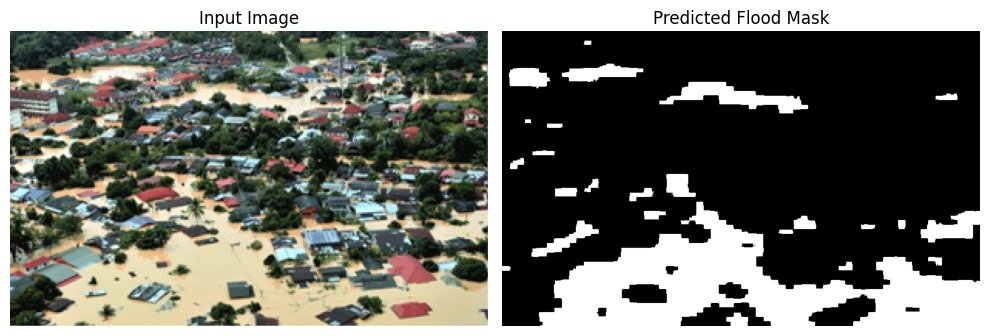

In [ ]:
from torchvision import transforms
from torchvision.transforms import functional as F

# preprocessing the input image
inference_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # same as ImageNet
                        std=[0.229, 0.224, 0.225])
])

image_path = os.path.join(IMAGE_DIR, "0.jpg")

# loading the model we just trained
model_path = "best_simple_segnet.pth"  # path to the saved model
model = SimpleSegNet().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

image = Image.open(image_path).convert("RGB")
input_tensor = inference_transform(image).unsqueeze(0).to(DEVICE)

# running the model with no gradient calculation
with torch.no_grad():
    output = model(input_tensor)  # (1, 1, H', W')
    pred_mask = output.squeeze(0)  # (1, H', W')
    pred_mask = F.resize(pred_mask, image.size[::-1])  # (1, H, W)
    pred_mask = pred_mask.squeeze(0).cpu().numpy()  # (H, W)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(pred_mask, cmap="gray")
axes[1].set_title("Predicted Flood Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# FINISHED! 🎉
